In [17]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import nibabel as nb
#from nilearn.image import resample_img
from sklearn import preprocessing
import matplotlib.colors as colors

In [18]:
func_file = 'sub-0050002_ses-1_task-rest_run-1_func_reorient.nii.gz'
mask_file = 'sub-0050002_ses-1_task-rest_run-1_functional_brain_mask.nii.gz'

In [19]:
# read in and mask the data 
func = nb.load(func_file)
mask = nb.load(mask_file)
mask_affine = mask.affine
mask = mask.get_data()

new_shape = func.shape[0]*func.shape[1]*func.shape[2]
func = func.get_data()
func = np.resize(func, (new_shape,func.shape[-1] ))

func = func[np.where( mask.ravel() == 1 )[0], :]

In [20]:
# z-score the rows so that they can be viewed on the same image
func = preprocessing.scale(func, axis=1)

/Users/cameron.craddock/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


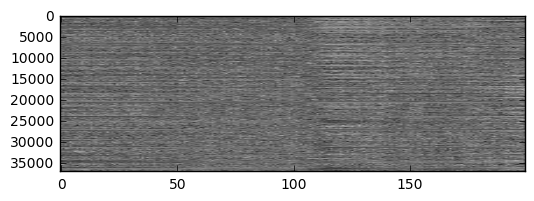

In [21]:
aspect = (float(func.shape[1])/float(func.shape[0]))/3.0
plt.imshow(func,cmap='gray', aspect=aspect)

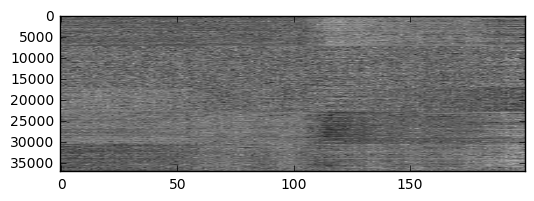

In [22]:
#now try some basic reordering
from sklearn.cluster.bicluster import SpectralBiclustering
model = SpectralBiclustering(n_clusters=(5,1),n_components=5, method='log',random_state=0)
model.fit(func)
reordered_func=func[np.argsort(model.row_labels_)]
plt.imshow(reordered_func,cmap='gray', aspect=aspect)

In [23]:
out_clusters=func[:,0]
func_max = func.max()+1
for i in range(0,5):
    out_clusters[model.get_indices(i)[0]]=int(i*2+func_max)
reordered_clusters=out_clusters[np.argsort(model.row_labels_)]
print reordered_clusters.shape, np.unique(reordered_clusters)

(37020,) [  8.  10.  12.  14.  16.]


[  8.  10.  12.  14.  16.] (37020, 202)
7.51113649843 -5.42845209458


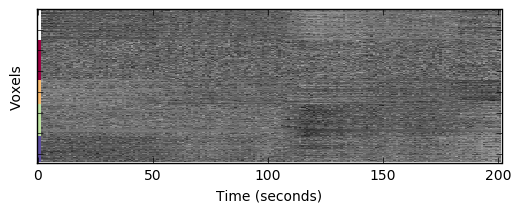

In [10]:
#add brain labels to grayplot

#color_plot = out_clusters[..., np.newaxis]
gray_plot = np.insert(reordered_func, 0, reordered_clusters, axis=1)
gray_plot = np.insert(gray_plot, 0, reordered_clusters, axis=1)
#gray_plot = np.insert(gray_plot, 0, reordered_clusters, axis=1)

print np.unique(reordered_clusters), gray_plot.shape
print reordered_func.max(), reordered_func.min()

from numpy.ma import masked_array
gray = masked_array(gray_plot,gray_plot>=func_max)
colors = masked_array(gray_plot,gray_plot<func_max)

fig,ax = plt.subplots()
pa = ax.imshow(gray,interpolation='None',cmap='gray',aspect=aspect)
pb = ax.imshow(colors,interpolation='None',cmap='Spectral',aspect=aspect)
plt.xlabel('Time (seconds)')
plt.ylabel('Voxels')
ax.yaxis.set_ticklabels([])
plt.savefig('grayplot.png', figsize=(8,24), dpi=400)

In [24]:
out_clusters_img=np.zeros(np.prod(mask.shape)) 
out_clusters_img[mask.ravel()==1]=reordered_clusters 
out_clusters_img=out_clusters_img.reshape(mask.shape) 
print np.unique(out_clusters_img)
out_clusters_img=np.zeros(np.prod(mask.shape))
out_clusters_img[mask.ravel()==1]=out_clusters 
out_clusters_img=out_clusters_img.reshape(mask.shape)
print np.unique(out_clusters_img)
print np.unique(out_clusters_img)[1]

[  0.   8.  10.  12.  14.  16.]
[  0.   8.  10.  12.  14.  16.]
8.0


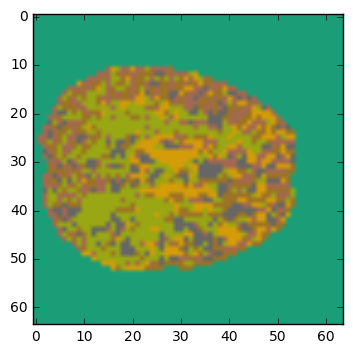

In [25]:
plt.imshow(out_clusters_img[:,:,18],cmap='Dark2',interpolation=None)

In [26]:
clust_img=nb.Nifti1Image(out_clusters_img, mask_affine)
nb.save(clust_img, "cluster_assignment.nii.gz")

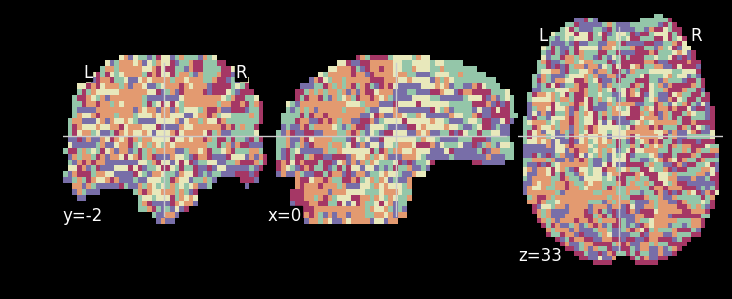

In [28]:
from nilearn import plotting
plotting.plot_roi(clust_img,mask_file,cmap='Spectral')